### License
> Copyright 2023 Anna Maria Krol
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [37]:
# python 3.9.18 kernel with Qiskit
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
# for use with older versions of Qiskit/Qiskit Aer
from qiskit import Aer
from qiskit import transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT, MCXGate

from helper_functions import combine_registers, grayCode
from operator_definitions import *
from count_valid_states import validate_state

# Calculating the value of the buffer per day

See QISS_1day for explanations for the functions used.

In [38]:

def bufferfor1day(circuit, buffer_qubits, s1_qubits, s1_shifts, s2_qubits, s2_shifts, ancilla_qubits, condition_qubit, B_max, min_prec):
    # B_out = B_init + S1 - S2
    add(circuit, s1_shifts, buffer_qubits, s1_qubits)
    subtract(circuit, s2_shifts, buffer_qubits, s2_qubits)

    # MAX(0, B_out)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    MAX0_B(circuit, buffer_qubits, ancilla_qubits)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # Condition c1: B_out <= B_max
    subtract(circuit, B_max+min_prec, buffer_qubits)

    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    circuit.cnot(buffer_qubits[-1], condition_qubit)
    circuit.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # uncompute
    add(circuit, B_max+min_prec, buffer_qubits)

# Variables

In [39]:
number_of_days = 2
B_init = 5
B_max = 10

shifts_s1 = [0,5,8,10]
shifts_s2 = [0,4,7,9]

V_target = 8*number_of_days
delta = round(0.05*V_target) # Just for debugging purposes, because should be 0.4 for 1 day, 0.08 for 2, but minimum precision = 1 so...
if delta == 0:
    delta = 1 # It can only be zero for running this for 1 day, but then there are no valid solutions so let's set it to 1
    
minimum_precision = 1
num_shop_qubits = 2
num_buffer_qubits = 6
num_ancillas = number_of_days*num_buffer_qubits

# Allocating the qubit registers

In [40]:

shop1_qubits = QuantumRegister(num_shop_qubits*number_of_days, name='qs1')
shop2_qubits = QuantumRegister(num_shop_qubits*number_of_days, name='qs2')
buffer_qubits = QuantumRegister(num_buffer_qubits, name='qb')

max_ancilla = QuantumRegister(num_ancillas, name='a')
condition_qubits = QuantumRegister(number_of_days+2, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(2*num_shop_qubits*number_of_days, name='cbits')

# Circuit and qubit initializaton

In [41]:
qc = QuantumCircuit(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, cbits)

# Initialize output qubit in state |->
qc.x(output_qubit)
qc.h(output_qubit)

# Initialize shop qubits in state |s>
qc.h(shop1_qubits)
qc.h(shop2_qubits)


# Making the oracle

Same as before, but now we do the buffer calculations for each day and calculate the (negated) output volume for all the days.

Each day has its own subset of the shop qubits, ancilla qubits and condition qubits,  all days use the same set of buffer qubits.

This is defined as a separate function to make it easier to apply the inverse oracle.

In [42]:
def oracle(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, number_of_days, B_init, B_max, shifts_s1, shifts_s2, V_target, delta, minimum_precision, num_shop_qubits, num_buffer_qubits):
    shftsched_oracle = QuantumCircuit(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit)

    shftsched_oracle.h(buffer_qubits)

    # Initial buffer content
    add(shftsched_oracle, B_init,buffer_qubits)

    # Calculate the buffer content (and condition) for each day
    for day in range(number_of_days):
            bufferfor1day(shftsched_oracle, buffer_qubits, shop1_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits], shifts_s1, shop2_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits], shifts_s2, max_ancilla[day*num_buffer_qubits:(day+1)*num_buffer_qubits], condition_qubits[day], B_max, minimum_precision)


    # Calculate (-)output volume: -V_out = B_final - S1 - B_init
    for day in range(number_of_days):
        subtract(shftsched_oracle, shifts_s1, buffer_qubits, shop1_qubits[day*num_shop_qubits:(day+1)*num_shop_qubits])
    subtract(shftsched_oracle, B_init, buffer_qubits)

    # condition c2: V_out >= V_low
    add(shftsched_oracle, V_target-delta-minimum_precision, buffer_qubits)

    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-2])
    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

    # condition c3: V_out <= V_up 
    add(shftsched_oracle, 2*delta + minimum_precision, buffer_qubits) 
    shftsched_oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
    shftsched_oracle.x(condition_qubits[-1])
    shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-1])

    # print("Oracle:")
    # print(shftsched_oracle)
    return shftsched_oracle


# Final circuit
We make the separate oracle circuit and append it to the main circuit. We do a CCCX to the output qubit, append the inverse oracle to the circuit to "reset" the qubits and use the diffuser to amplify the marked states.

In [43]:
shftsched_oracle = oracle(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, number_of_days, B_init, B_max, shifts_s1, shifts_s2, V_target, delta, minimum_precision, num_shop_qubits, num_buffer_qubits)
qc.append(shftsched_oracle, qc.qubits)

# CCCX gate on all conditionals to the |-> qubit
qc.append(MCXGate(len(condition_qubits)), combine_registers(condition_qubits, output_qubit))

# uncompute
qc.append(shftsched_oracle.inverse(), qc.qubits)

diffuser(qc, combine_registers(shop1_qubits, shop2_qubits))

# measure the shop qubits
qc.measure(combine_registers(shop1_qubits, shop2_qubits), cbits)
print(qc.decompose())

/tmp/ipykernel_32160/3671055290.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  circuit.cnot(buffer_qubits[-1], condition_qubit)
/tmp/ipykernel_32160/1198089394.py:23: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-2])
/tmp/ipykernel_32160/1198089394.py:30: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  shftsched_oracle.cnot(buffer_qubits[-1], condition_qubits[-1

          ┌─────────┐            ┌──────┐                               »
  qs1_0: ─┤ U2(0,π) ├────────────┤0     ├───────────────────────────────»
          ├─────────┤            │      │                               »
  qs1_1: ─┤ U2(0,π) ├────────────┤1     ├───────────────────────────────»
          ├─────────┤            │      │                               »
  qs1_2: ─┤ U2(0,π) ├────────────┤      ├───────────────────────────────»
          ├─────────┤            │      │                               »
  qs1_3: ─┤ U2(0,π) ├────────────┤      ├───────────────────────────────»
          ├─────────┤            │      │┌──────┐                       »
  qs2_0: ─┤ U2(0,π) ├────────────┤      ├┤0     ├───────────────────────»
          ├─────────┤            │      ││      │                       »
  qs2_1: ─┤ U2(0,π) ├────────────┤      ├┤1     ├───────────────────────»
          ├─────────┤            │      ││      │                       »
  qs2_2: ─┤ U2(0,π) ├────────────┤    

# Simulation

Instantiation of the simulator and the simulation of the circuit itself

In [44]:
# simulator = Aer.get_backend('aer_simulator_matrix_product_state', max_memory_mb=32868) # for older versions of Qiskit/Qiskit Aer
simulator = AerSimulator(method='matrix_product_state', max_memory_mb=1015815)

circ = transpile(qc, simulator)
nshots = 1000
result = simulator.run(circ, shots=nshots).result()
counts = result.get_counts(circ)

# Plotting

We separate the results into valid/invalid states, so we can plot them easily using different colors. For each valid state, there is a 0 in the measurement counts of the invalid states and vice versa. This also means that states that have never been measured are still included in the width of the plot (as bars with 0 length), otherwise they would be skipped.

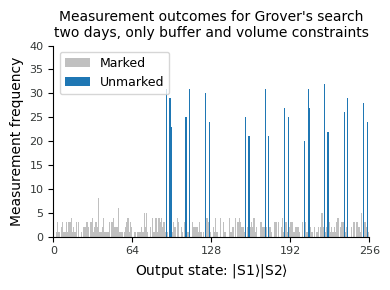

In [45]:
fig, ax = plt.subplots(figsize=(4,3))
selected_counts_dict = {}
unmarked_counts_moredays = [0]*(2**(2*num_shop_qubits*number_of_days))
marked_counts_moredays = [0]*(2**(2*num_shop_qubits*number_of_days))
defaultcolor = 'silver'
markedcolor = '#1f77b4'

sortdict =  sorted(counts.items())

for key, value in sortdict:
        newkey = int(key[::-1], 2)
        if validate_state(key[::-1], number_of_days):
            marked_counts_moredays[newkey] = value
            # # uncomment for double-width "valid" bars
            # if marked_counts_moredays[newkey-1] < value:
            #      marked_counts_moredays[newkey-1] = value
        else:
            unmarked_counts_moredays[newkey] = value
plt.margins(x=0)

plt.hist([range(len(unmarked_counts_moredays))], stacked=True, bins=(range(len(unmarked_counts_moredays)+1)), weights=[unmarked_counts_moredays], color=[defaultcolor],rwidth=1) 
plt.hist([range(len(marked_counts_moredays))], stacked=True, bins=(range(len(marked_counts_moredays)+1)), weights=[marked_counts_moredays], color=[markedcolor], rwidth=1) 
plt.xlabel("Output state: |S1$\\rangle$|S2$\\rangle$",size=10)
plt.xticks(range(0,len(unmarked_counts_moredays)+1,4**(number_of_days+1)), color='#343837', size=8)
plt.legend(["Marked", "Unmarked"], loc='upper left', fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

numberdays = ["zero days", "one day", "two days", "three days", "four days", "five days", "six days", "seven days", "eight days", "nine days", "ten days"]
plt.yticks(range(0,max(marked_counts_moredays)+10,5), color='#343837', size=8)
plt.ylabel("Measurement frequency",size=10)
plt.title("Measurement outcomes for Grover's search\n" + numberdays[number_of_days] + ", only buffer and volume constraints", size=10)

fig.tight_layout()
plt.show()

Uncomment to save the figure

In [46]:
# filename = "QISS_Grovers_" + str(number_of_days) + "days_no_cost.eps"
# fig.savefig(filename, format='eps')